In [229]:
import pandas as pd
import numpy as np
import scipy as sp
import torch
import os
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import matplotlib as mpl
import glob
from yaml import Loader, load
import pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import fiona
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt
from matplotlib.ticker import FixedLocator
import geopandas as gpd

In [230]:
def plot_fluxes(G, voronoi, inner_radars, countries, crs, ax, 
                extent=[-4, 16, 41, 56], max_flux=100, bird_scale=1, cbar=True, boundary=True):

    f = ShapelyFeature(countries.geometry,
            ccrs.PlateCarree(), edgecolor='white')
    ax.set_extent(extent)
    ax.add_feature(f, facecolor='lightgray', zorder=1)

    coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                     observed = voronoi.observed,
                                     geometry = [geometry.Point((row.lon, row.lat)) for 
                                                 i, row in voronoi.iterrows()]), 
                                     crs='epsg:4326').to_crs(crs)
    pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, 
                  coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
           (ridx, name) in nx.get_node_attributes(G, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G,'flux').values()))
    fluxes *= bird_scale
    edge_widths = np.minimum(fluxes, max_flux) / (0.25 * max_flux) + 1.2

    c_radar = 'lightgray'
    c_marker = '#0a3142'
    node_colors = ['#999999' if 'boundary' in n_data['radar'] else c_radar for n, n_data in G.nodes(data=True)]
    node_colors = [c_radar for n, n_data in G.nodes(data=True)]

    cmap = cm.get_cmap('YlOrRd')

    norm = plt.Normalize(0, max_flux)
    edge_colors = cmap(norm(fluxes))

    nx.draw(G, pos=pos, with_labels=False, node_size=9000/len(G), node_color=node_colors, ax=ax, 
            connectionstyle="arc3,rad=0.1", edge_color=edge_colors, width=edge_widths)

    gplt.polyplot(coord_df.query('observed == 1').buffer(20_000).to_crs(epsg=4326), 
                  ax=ax, extent=extent, zorder=3, edgecolor=c_marker, linewidth=1.5)
    gplt.pointplot(coord_df.query('observed == 1').to_crs(epsg=4326), 
                   ax=ax, extent=extent, zorder=4, color=c_marker, s=6)
    if boundary:
         gplt.polyplot(coord_df.query('observed == 0').buffer(20_000).to_crs(epsg=4326), 
                  ax=ax, extent=extent, zorder=3, edgecolor=c_marker, linewidth=2)
    else:
        gplt.polyplot(coord_df.query('observed == 0').buffer(20_000).to_crs(epsg=4326), 
                  ax=ax, extent=extent, zorder=0, edgecolor=c_marker, linewidth=2)


    if cbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = plt.colorbar(sm, extend='max', pad=0.1)
        cbar.set_label(label=r'net migratory flux [birds per night]',size=24, labelpad=18)
        cbar.ax.tick_params(labelsize=14) 

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=1, color='gray', alpha=0.25, linestyle='--')

    xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
    yspacing = FixedLocator([40, 45, 50, 55])
    gl.xlocator = xspacing
    gl.ylocator = yspacing

    ax.set_extent(extent)

    return ax

In [231]:
home = osp.expanduser("~")
base_dir = osp.join(home, 'Documents', 'FluxRGNN')
model_dir = osp.join(base_dir, 'results', 'abm', 'FluxRGNN', 'test_2017', 'final')
prep_dir = osp.join(base_dir, 'data', 'preprocessed', '1H_voronoi_ndummy=25', 'abm', 'fall', '2017')
shape_dir = osp.join(base_dir, 'data', 'shapes')
figure_dir = osp.join(base_dir, 'data', 'plots', 'final')
os.makedirs(figure_dir, exist_ok=True)

In [232]:
c_radar_loc = '#cc3300'
c_radar_area = '#347B98'
c_marker = '#0a3142'
c_boundary = '#092834'
c_boundary_rgb = (9/255, 40/255, 52/255, 0.2)
c_boundary_light = '#0a3142'
c_text = '#262626'
c_countries = 'lightgray'

### ***Analysis of spatial fluxes***

In [233]:
ext = '_fixedT0'
path = osp.join(model_dir, f'performance_evaluation{ext}', '1-24')

In [9]:
corr_d2b = pd.read_csv(osp.join(path, 'agg_corr_d2b_per_trial.csv'))
corr_angles = pd.read_csv(osp.join(path, 'agg_corr_angles_per_trial.csv'))
bins_per_trial = pd.read_csv(osp.join(path, 'agg_bins_per_trial.csv'))

with open(osp.join(path, 'agg_overall_corr.pickle'), 'rb') as f:
    overall_corr = pickle.load(f)
    
mean_corr = np.mean(list(overall_corr.values()))
std_corr = np.std(list(overall_corr.values()))
print(f'overall correlation = {mean_corr} +/- {std_corr}')

mean_acc = bins_per_trial.accuracy.mean()
std_acc = bins_per_trial.accuracy.std()
print(f'overall accuracy of directions = {mean_acc} +/- {std_acc}')

overall correlation = 0.6416101016479174 +/- 0.04312637627651095
overall accuracy of directions = 0.8719607276927521 +/- 0.007843625213432157


In [12]:
all_fluxes = pd.read_csv(osp.join(path, 'all_fluxes_per_trial.csv'))

inner_radars = [r for r in all_fluxes.radar1.unique() if not 'boundary' in str(r)]
boundary_radars = [r for r in all_fluxes.radar1.unique() if 'boundary' in str(r)]
idx1 = all_fluxes.radar1.isin(inner_radars).values
idx2 = all_fluxes.radar2.isin(inner_radars).values
jdx1 = all_fluxes.radar1.isin(boundary_radars).values
jdx2 = all_fluxes.radar2.isin(boundary_radars).values

### Inner fluxes (between observed Voronoi cells)

fit coefficients: [ 5.28420564e-01 -3.18259591e-16]


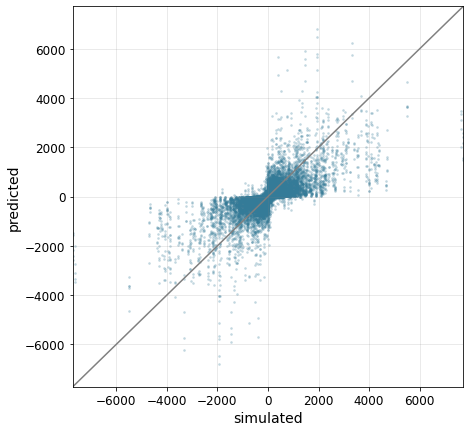

In [50]:
data = all_fluxes[np.logical_and(idx1, idx2)]
x = data['gt_flux'].values
y = data['model_flux'].values
mask = np.isfinite(x)
x = x[mask]
y = y[mask]

coef = np.polyfit(x,y,1)
print('fit coefficients:', coef)
poly1d_fn = np.poly1d(coef) 

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(x,y, alpha=.2, s=3, c=c_radar_area)
#ax.plot(x, poly1d_fn(x), ls='--', color='gray')
ax.plot(np.linspace(x.min(), x.max()), np.linspace(x.min(), x.max()), ls='-', color='gray')

ax.set_xlabel('simulated', fontsize=14)
ax.set_ylabel('predicted', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set(xlim=(x.min(), x.max()), ylim=(x.min(), x.max()))
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='both')
fig.savefig(osp.join(figure_dir, f'corr_fluxes_all_trials_without_boundary{ext}.png'), bbox_inches='tight', dpi=200)

### Boundary fluxes only

fit coefficients: [7.39264777e-01 1.09280026e-16]


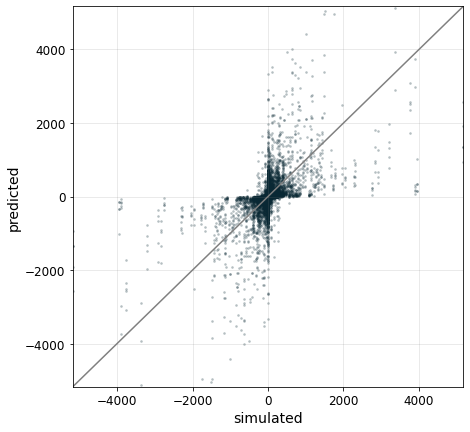

In [51]:
data = all_fluxes[np.logical_or(np.logical_and(idx1, jdx2), np.logical_and(idx2, jdx1))]
x = data['gt_flux'].values
y = data['model_flux'].values
mask = np.isfinite(x)
x = x[mask]
y = y[mask]

coef = np.polyfit(x,y,1)
print('fit coefficients:', coef)
poly1d_fn = np.poly1d(coef) 

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(x,y, alpha=.2, s=3, c=c_boundary)
ax.plot(np.linspace(x.min(), x.max()), np.linspace(x.min(), x.max()), ls='-', color='gray')

ax.set_xlabel('simulated', fontsize=14)
ax.set_ylabel('predicted', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set(xlim=(x.min(), x.max()), ylim=(x.min(), x.max()))
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='both')
fig.savefig(osp.join(figure_dir, f'corr_fluxes_all_trials_boundary_only{ext}.png'), bbox_inches='tight', dpi=200)

### Correlation per distance to boundary

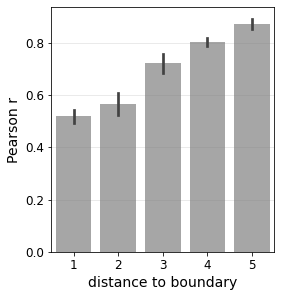

In [13]:
fig, ax = plt.subplots(figsize=(4,4.5))
sb.barplot(x='d2b', y='corr', data=corr_d2b.dropna(), ax=ax, 
           color='#a6a6a6', ci='sd')
ax.set_xlabel('distance to boundary', fontsize=14)
ax.set_ylabel('Pearson r', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y')
fig.savefig(osp.join(figure_dir, f'pcc_acc_fluxes_per_d2b_trial_std{ext}.png'), bbox_inches='tight', dpi=200)

In [65]:
print('mean pearson r per', corr_d2b.groupby('d2b').aggregate(np.mean)['corr'])
print('std pearson r per', corr_d2b.groupby('d2b').aggregate(np.std)['corr'])

mean pearson r per d2b
1    0.518996
2    0.565437
3    0.722931
4    0.803720
5    0.873095
Name: corr, dtype: float64
std pearson r per d2b
1    0.026378
2    0.047868
3    0.040464
4    0.018037
5    0.021920
Name: corr, dtype: float64


### ***Analysis of nightly fluxes and source/sink terms***

mean Pearson r:
 type
influx     0.748825
outflux    0.689310
sink       0.535040
source     0.604415
Name: corr, dtype: float64
std Pearson r:
 type
influx     0.033593
outflux    0.051682
sink       0.051553
source     0.018840
Name: corr, dtype: float64


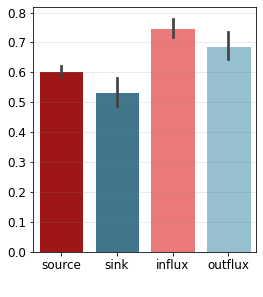

In [195]:
all_corr = {'trial': [], 'type': [], 'corr': []}

sinks = pd.read_csv(osp.join(path, 'all_sinks.csv'))
sources = pd.read_csv(osp.join(path, 'all_sources.csv'))
fluxes = pd.read_csv(osp.join(path, 'all_fluxes_per_radar.csv'))
voronoi = pd.read_csv(osp.join(path, 'voronoi_summary.csv'))

d2b = 1
radars = voronoi.query(f'dist2boundary > {d2b}').radar.values

for t in range(1, 6):
    sources_t = sources[sources.radar.isin(radars)].query(f'trial == {t}')
    all_corr['corr'].append(sp.stats.pearsonr(sources_t['gt'].values, sources_t['model'].values)[0])
    all_corr['type'].append('source')

    sinks_t = sinks[sinks.radar.isin(radars)].query(f'trial == {t}')
    all_corr['corr'].append(sp.stats.pearsonr(sinks_t['gt'].values, sinks_t['model'].values)[0])
    all_corr['type'].append('sink')

    fluxes_t = fluxes[fluxes.radar.isin(radars)].query(f'trial == {t}')
    all_corr['corr'].append(sp.stats.pearsonr(fluxes_t['gt_influx'].values, fluxes_t['model_influx'].values)[0])
    all_corr['type'].append('influx')

    all_corr['corr'].append(sp.stats.pearsonr(fluxes_t['gt_outflux'].values, fluxes_t['model_outflux'].values)[0])
    all_corr['type'].append('outflux')

    all_corr['trial'].extend([t] * 4)
    
all_corr = pd.DataFrame(all_corr)

palette = {"source": "#B50000", "sink": "#347B98", "influx": "#ff6666", "outflux": "#8dc3d8"}
fig, ax = plt.subplots(figsize=(4,4.5))
sb.barplot(data=all_corr, x='type', y='corr', ax=ax,
           palette=palette, ci='sd', edgecolor="white")
ax.set_ylabel('')
ax.set_xlabel(' ', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y');
fig.savefig(osp.join(figure_dir, f'pcc_nightly_source_sink_fluxes_per_trial_d2b>1.png'), 
            bbox_inches='tight', dpi=200)

print('mean Pearson r:\n', all_corr.groupby('type')['corr'].mean())
print('std Pearson r:\n', all_corr.groupby('type')['corr'].std())

mean Pearson r:
 type
influx     0.811047
outflux    0.785742
sink       0.645969
source     0.672839
Name: corr, dtype: float64
std Pearson r:
 type
influx     0.034720
outflux    0.038352
sink       0.015392
source     0.012332
Name: corr, dtype: float64


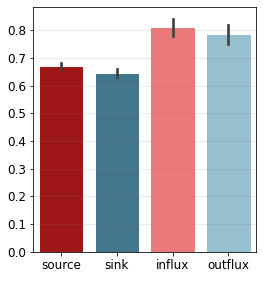

In [193]:
all_corr = {'trial': [], 'type': [], 'corr': []}

sinks = pd.read_csv(osp.join(path, 'all_sinks.csv'))
sources = pd.read_csv(osp.join(path, 'all_sources.csv'))
fluxes = pd.read_csv(osp.join(path, 'all_fluxes_per_radar.csv'))
voronoi = pd.read_csv(osp.join(path, 'voronoi_summary.csv'))

d2b = 2
radars = voronoi.query(f'dist2boundary > {d2b}').radar.values

for t in range(1, 6):
    sources_t = sources[sources.radar.isin(radars)].query(f'trial == {t}')
    all_corr['corr'].append(sp.stats.pearsonr(sources_t['gt'].values, sources_t['model'].values)[0])
    all_corr['type'].append('source')

    sinks_t = sinks[sinks.radar.isin(radars)].query(f'trial == {t}')
    all_corr['corr'].append(sp.stats.pearsonr(sinks_t['gt'].values, sinks_t['model'].values)[0])
    all_corr['type'].append('sink')

    fluxes_t = fluxes[fluxes.radar.isin(radars)].query(f'trial == {t}')
    all_corr['corr'].append(sp.stats.pearsonr(fluxes_t['gt_influx'].values, fluxes_t['model_influx'].values)[0])
    all_corr['type'].append('influx')

    all_corr['corr'].append(sp.stats.pearsonr(fluxes_t['gt_outflux'].values, fluxes_t['model_outflux'].values)[0])
    all_corr['type'].append('outflux')

    all_corr['trial'].extend([t] * 4)
    #all_corr['d2b'].extend([d2b] * 4)
    
all_corr = pd.DataFrame(all_corr)

palette = {"source": "#B50000", "sink": "#347B98", "influx": "#ff6666", "outflux": "#8dc3d8"}
fig, ax = plt.subplots(figsize=(4,4.5))
sb.barplot(data=all_corr, x='type', y='corr', ax=ax,
           palette=palette, ci='sd', edgecolor="white")
ax.set_ylabel('')
ax.set_xlabel(' ', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xticklabels(['August', 'September', 'October', 'November'])
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=len(all_corr.type.unique()), framealpha=1, fontsize=12)
#ax.set(ylim=(0, 0.75))
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y');
fig.savefig(osp.join(figure_dir, f'pcc_nightly_source_sink_fluxes_per_trial_d2b>2.png'), 
            bbox_inches='tight', dpi=200)

print('mean Pearson r:\n', all_corr.groupby('type')['corr'].mean())
print('std Pearson r:\n', all_corr.groupby('type')['corr'].std())

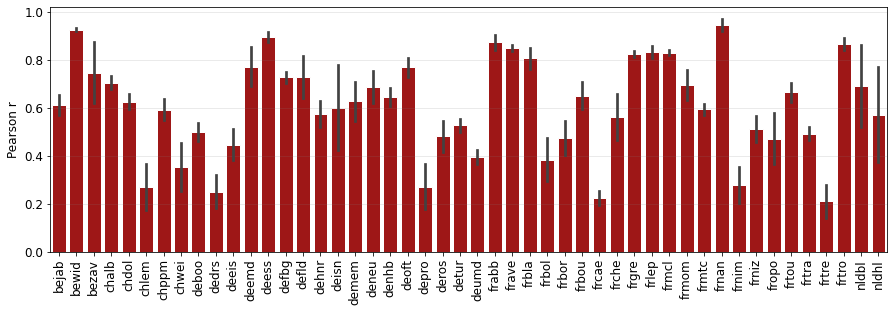

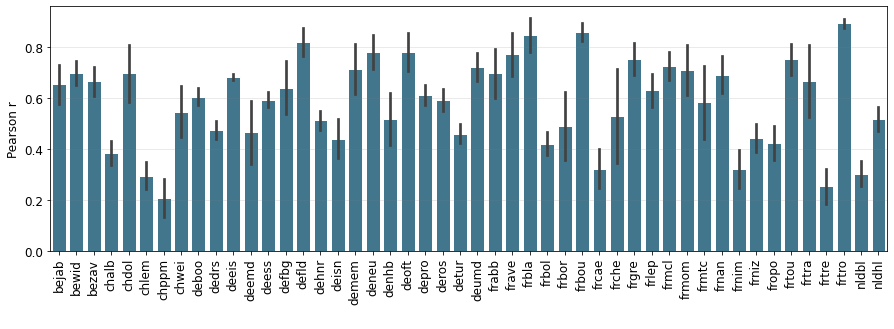

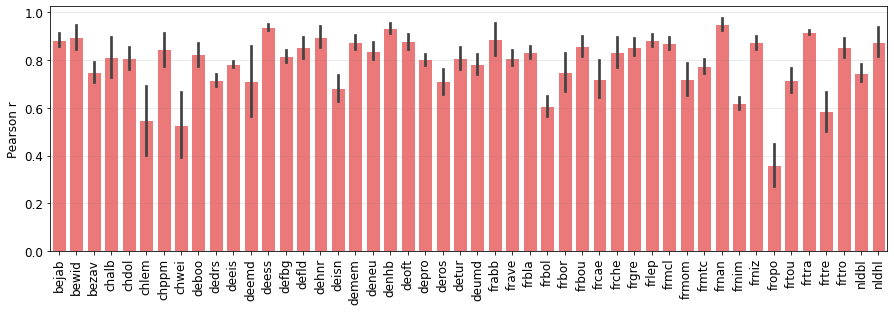

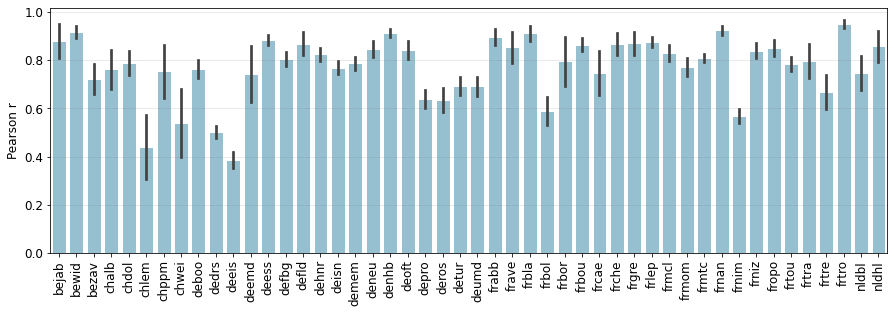

In [220]:
all_corr = {'trial': [], 'type': [], 'corr': [], 'radar': []}

sinks = pd.read_csv(osp.join(path, 'all_sinks.csv'))
sources = pd.read_csv(osp.join(path, 'all_sources.csv'))
fluxes = pd.read_csv(osp.join(path, 'all_fluxes_per_radar.csv'))
voronoi = pd.read_csv(osp.join(path, 'voronoi_summary.csv'))

#d2b = 1
#radars = voronoi.query(f'dist2boundary > {d2b} ').radar.values
radars = sinks.radar.unique()

for t in range(1, 6):
    for r in radars:
        sources_t = sources.query(f'trial == {t} & radar == "{r}"')
        #print(t, r)
        all_corr['corr'].append(sp.stats.pearsonr(sources_t['gt'].values, sources_t['model'].values)[0])
        all_corr['type'].append('source')

        sinks_t = sinks.query(f'trial == {t} & radar == "{r}"')
        all_corr['corr'].append(sp.stats.pearsonr(sinks_t['gt'].values, sinks_t['model'].values)[0])
        all_corr['type'].append('sink')

        fluxes_t = fluxes.query(f'trial == {t} & radar == "{r}"')
        all_corr['corr'].append(sp.stats.pearsonr(fluxes_t['gt_influx'].values, fluxes_t['model_influx'].values)[0])
        all_corr['type'].append('influx')

        all_corr['corr'].append(sp.stats.pearsonr(fluxes_t['gt_outflux'].values, fluxes_t['model_outflux'].values)[0])
        all_corr['type'].append('outflux')

        all_corr['trial'].extend([t] * 4)
        all_corr['radar'].extend([r] * 4)
    #all_corr['d2b'].extend([d2b] * 4)
    
all_corr = pd.DataFrame(all_corr)

palette = {"source": "#B50000", "sink": "#347B98", "influx": "#ff6666", "outflux": "#8dc3d8"}

for k in palette.keys():
    fig, ax = plt.subplots(figsize=(15,4.5))
    sb.barplot(data=all_corr.query(f'type == "{k}"'), x='radar', y='corr', ax=ax,
               color=palette[k], ci='sd', edgecolor="white")
    ax.set_ylabel('Pearson r', fontsize=12)
    ax.set_xlabel(' ', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.set_xticklabels(['August', 'September', 'October', 'November'])
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=len(all_corr.type.unique()), framealpha=1, fontsize=12)
    #ax.set(ylim=(0, 0.75))
    plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y')
    plt.xticks(rotation=90)
    fig.savefig(osp.join(figure_dir, f'pcc_nightly_{k}_per_radar.png'), 
                bbox_inches='tight', dpi=200)

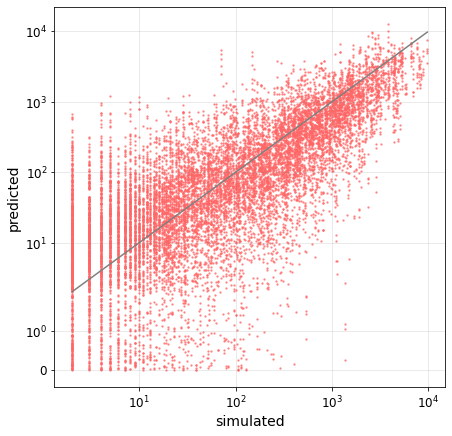

In [171]:
data = pd.read_csv(osp.join(path, 'all_fluxes_per_radar.csv'))
data = data.query('gt_influx > 1')
data = data[data.radar.isin(inner_radars)]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(data['gt_influx'].values, data['model_influx'].values, 
           alpha=.6, s=2, c="#ff6666")#, label='influx')
#ax.scatter(data['gt_outflux'].values, data['model_outflux'].values, 
#           alpha=.4, s=5, c="#8dc3d8", label='outflux')
ax.plot(np.linspace(x.min(), x.max()), np.linspace(x.min(), x.max()), ls='-', color='gray')

ax.set_xlabel('simulated', fontsize=14)
ax.set_ylabel('predicted', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set(xlim=(x.min(), x.max()), ylim=(x.min(), x.max()))
ax.set_xscale('symlog')
ax.set_yscale('symlog')
#ax.legend(fontsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='both')
fig.savefig(osp.join(figure_dir, f'influx_scatter.png'), bbox_inches='tight', dpi=200)

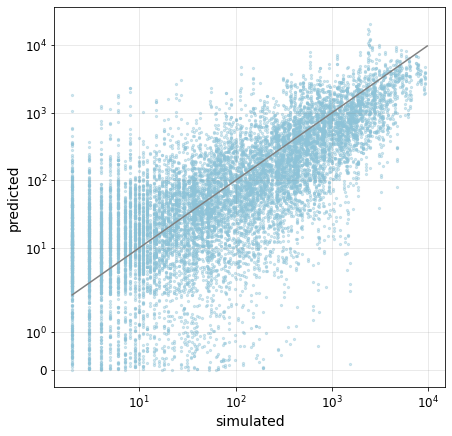

In [170]:
data = pd.read_csv(osp.join(path, 'all_fluxes_per_radar.csv'))
data = data.query('gt_outflux > 1')
data = data[data.radar.isin(inner_radars)]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(data['gt_outflux'].values, data['model_outflux'].values, 
          alpha=.4, s=5, c="#8dc3d8")
ax.plot(np.linspace(x.min(), x.max()), np.linspace(x.min(), x.max()), ls='-', color='gray')

ax.set_xlabel('simulated', fontsize=14)
ax.set_ylabel('predicted', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set(xlim=(x.min(), x.max()), ylim=(x.min(), x.max()))
ax.set_xscale('symlog')
ax.set_yscale('symlog')
#ax.legend(fontsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='both')
fig.savefig(osp.join(figure_dir, f'outflux_scatter.png'), bbox_inches='tight', dpi=200)

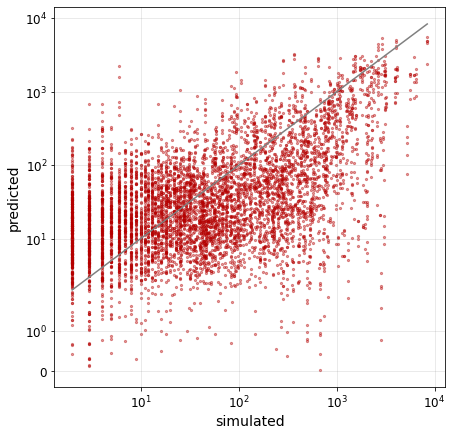

In [172]:
data = pd.read_csv(osp.join(path, 'all_sources.csv'))
data = data.query('gt > 1')

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(data['gt'].values, data['model'].values, 
          alpha=.4, s=5, c="#B50000")
ax.plot(np.linspace(data['gt'].min(), data['gt'].max()), 
        np.linspace(data['gt'].min(), data['gt'].max()), ls='-', color='gray')

ax.set_xlabel('simulated', fontsize=14)
ax.set_ylabel('predicted', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xscale('symlog')
ax.set_yscale('symlog')
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='both')
fig.savefig(osp.join(figure_dir, f'source_scatter.png'), bbox_inches='tight', dpi=200)

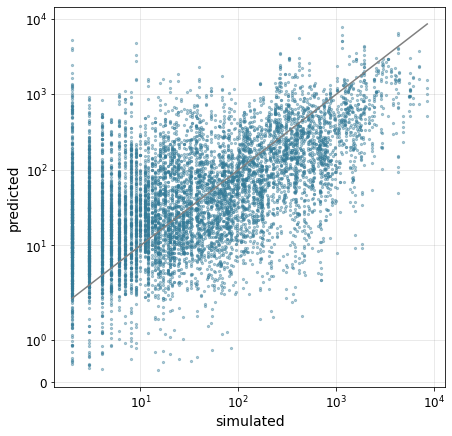

In [153]:
data = pd.read_csv(osp.join(path, 'all_sinks.csv'))
data = data.query('gt > 1')

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(data['gt'].values, data['model'].values, 
          alpha=.4, s=5, c="#347B98")
ax.plot(np.linspace(data['gt'].min(), data['gt'].max()), 
        np.linspace(data['gt'].min(), data['gt'].max()), ls='-', color='gray')

ax.set_xlabel('simulated', fontsize=14)
ax.set_ylabel('predicted', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xscale('symlog')
ax.set_yscale('symlog')
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='both')
fig.savefig(osp.join(figure_dir, f'sink_scatter.png'), bbox_inches='tight', dpi=200)

In [200]:
sinks = pd.read_csv(osp.join(path, 'all_sinks.csv'))
sources = pd.read_csv(osp.join(path, 'all_sources.csv'))
fluxes = pd.read_csv(osp.join(path, 'all_fluxes_per_radar.csv'))

corr_per_radar = {'radar': [], 'sink_corr': [], 'source_corr': [], 'influx_corr': [], 'outflux_corr': []}

for r in data['radar'].unique():
    df_sink = sinks.query(f'radar == "{r}"')
    df_source = sources.query(f'radar == "{r}"')
    df_fluxes = fluxes.query(f'radar == "{r}"')

    corr_per_radar['sink_corr'].append(np.corrcoef(df_sink["gt"].values, df_sink.model.values)[0,1])
    corr_per_radar['source_corr'].append(np.corrcoef(df_source["gt"].values, df_source.model.values)[0,1])
    corr_per_radar['influx_corr'].append(np.corrcoef(df_fluxes["gt_influx"].values, df_fluxes.model_influx.values)[0,1])
    corr_per_radar['outflux_corr'].append(np.corrcoef(df_fluxes["gt_outflux"].values, df_fluxes.model_outflux.values)[0,1])
    
    corr_per_radar['radar'].append(r)
corr_per_radar = pd.DataFrame(corr_per_radar)

In [222]:
data = pd.read_csv(osp.join(path, 'all_sinks.csv'))

for r in data['radar'].unique():
    df = data.query(f'radar == "{r}"')
    cc = np.corrcoef(df["gt"].values, df.model.values)[0,1]
    if cc < 0.3:
        print(f'{r}: {cc}')

chlem: 0.29309651115100915
chppm: 0.204416475547462
frtre: 0.22696007652390346
nldbl: 0.2897393489361743


In [165]:
data = pd.read_csv(osp.join(path, 'all_fluxes_per_radar.csv'))
for r in data['radar'].unique():
    df = data.query(f'radar == "{r}"')
    cc = np.corrcoef(df["gt_influx"].values, df.model_influx.values)[0,1]
    if cc < 0.4:
        print(f'{r}: {cc}')

fropo: 0.3631864935068599
boundary_2: -0.02349561309353299
boundary_3: -0.02181732050232453
boundary_4: 0.2560896533553483
boundary_13: 0.2302320649526321
boundary_17: 0.30069119350276097
boundary_24: 0.29972667050803115


/home/fiona/anaconda3/envs/fluxrgnn/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/fiona/anaconda3/envs/fluxrgnn/lib/python3.9/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


### ***Analysis of nightly fluxes and source/sink terms per month***

In [14]:
all_corr_source = pd.read_csv(osp.join(path, 'agg_source_corr_per_trial.csv'))
all_corr_sink = pd.read_csv(osp.join(path, 'agg_sink_corr_per_trial.csv'))

print('######## source ##########')
mean_corr = all_corr_source['corr'].aggregate(np.nanmean)
std_corr = all_corr_source['corr'].std()
print(f'overall correlation = {mean_corr} +/- {std_corr}')
print('########  sink  ##########')
mean_corr = all_corr_sink['corr'].mean()
std_corr = all_corr_sink['corr'].std()
print(f'overall correlation = {mean_corr} +/- {std_corr}')

######## source ##########
overall correlation = 0.6107760576783917 +/- 0.019741393213428302
########  sink  ##########
overall correlation = 0.5181388400240483 +/- 0.045975861315995924


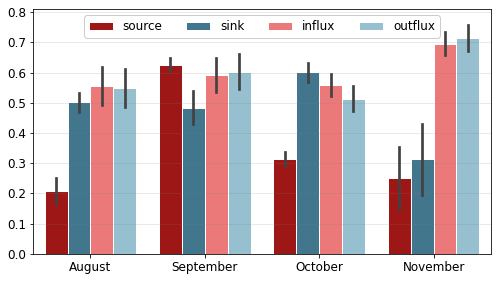

In [23]:
corr_source = pd.read_csv(osp.join(path, 'agg_source_corr_per_month_and_trial.csv'))
corr_sink = pd.read_csv(osp.join(path, 'agg_sink_corr_per_month_and_trial.csv'))
corr_influx = pd.read_csv(osp.join(path, 'agg_corr_influx_per_month.csv'))
corr_outflux = pd.read_csv(osp.join(path, 'agg_corr_outflux_per_month.csv'))

corr_sink['type'] = 'sink'
corr_source['type'] = 'source'
corr_influx['type'] = 'influx'
corr_outflux['type'] = 'outflux'

all_corr = pd.concat([corr_source[['trial', 'corr', 'type', 'month']], 
                      corr_sink[['trial', 'corr', 'type', 'month']],
                     corr_influx[['trial', 'corr', 'type', 'month']],
                     corr_outflux[['trial', 'corr', 'type', 'month']]])

palette = {"source": "#B50000", "sink": "#347B98", "influx": "#ff6666", "outflux": "#8dc3d8"}
fig, ax = plt.subplots(figsize=(8.2,4.5))
sb.barplot(data=all_corr, x='month', hue='type', y='corr', ax=ax,
           palette=palette, ci='sd', edgecolor="white")
ax.set_ylabel('')
ax.set_xlabel(' ', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticklabels(['August', 'September', 'October', 'November'])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=len(all_corr.type.unique()), framealpha=1, fontsize=12)
ax.set(ylim=(0, 0.81))
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y');
fig.savefig(osp.join(figure_dir, f'pcc_agg_source_sink_fluxes_per_month_trial_std_final{ext}.png'), 
            bbox_inches='tight', dpi=200)

### ***Visualisation of 24h fluxes***

### FluxRGNN prediction

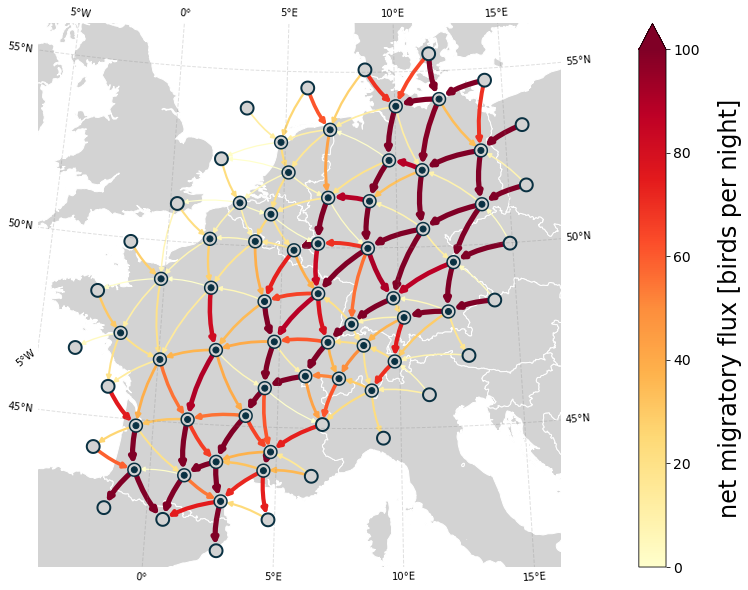

In [58]:
trial = 3

G = nx.read_gpickle(osp.join(model_dir, f'performance_evaluation{ext}', '1-24', f'model_fluxes_{trial}.gpickle'))
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values
countries = gpd.read_file(osp.join(shape_dir, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})

ax = plot_fluxes(G, voronoi, inner_radars, countries, crs.proj4_init, ax, cbar=True)

fig.savefig(osp.join(figure_dir, f'abm_avg_24h_fluxes_model_trial{trial}{ext}.png'), bbox_inches='tight', dpi=200)

### Simulated fluxes (ground truth)

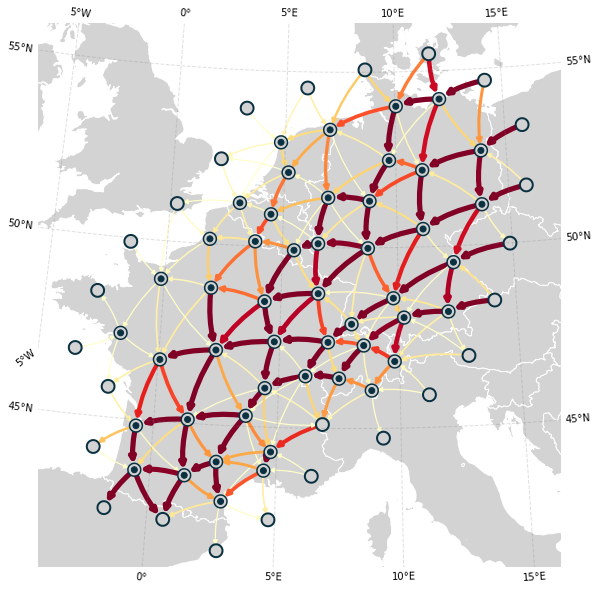

In [48]:
G = nx.read_gpickle(osp.join(model_dir, f'performance_evaluation{ext}', '1-24', f'gt_fluxes.gpickle'))
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values
countries = gpd.read_file(osp.join(shape_dir, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})

ax = plot_fluxes(G, voronoi, inner_radars, countries, crs.proj4_init, ax, cbar=False)

fig.savefig(osp.join(figure_dir, f'abm_avg_24h_fluxes_gt{ext}.png'), bbox_inches='tight', dpi=200)

### ***Time series comparison***

In [31]:
voronoi_data = pd.read_csv(osp.join(model_dir, 'performance_evaluation', '24-24', 'voronoi_summary.csv'))

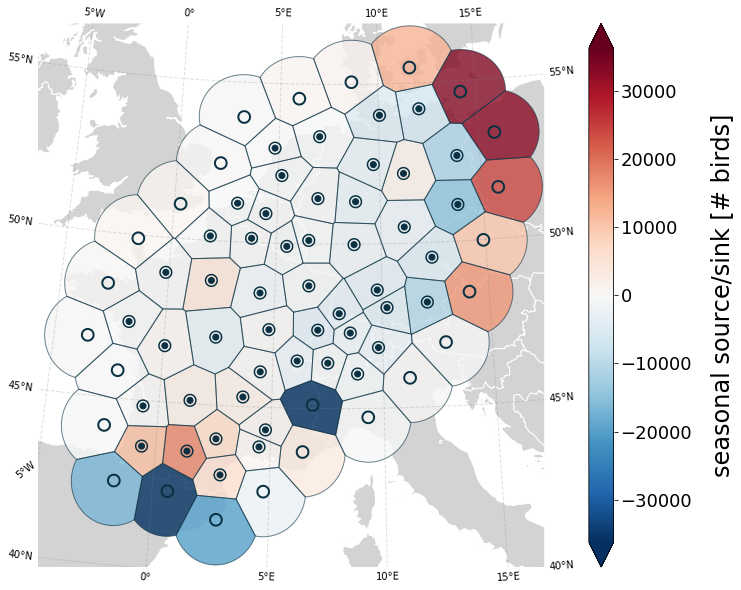

In [50]:
fig, ax = plt.subplots(figsize=(16, 10), subplot_kw = {'projection' : crs})
extent = [-4.5, 16.5, 40, 56.5]

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)

trial = 2

voronoi['net_flux'] = voronoi_data[f'net_flux_{trial}'].values
voronoi['net_s'] = voronoi_data[f'net_source_sink_{trial}'].values
voronoi['net_s'] *= voronoi.area_km2

abs_max_f = max(voronoi[f'net_flux'].max(), -voronoi[f'net_flux'].min())
abs_max_s = max(voronoi[f'net_s'].max(), -voronoi[f'net_s'].min())
abs_max = max(abs_max_f, abs_max_s)
norm = mpl.colors.Normalize(vmin=-abs_max*0.75, vmax=abs_max*0.75)

gplt.choropleth(voronoi.query('boundary == 1'), ax=ax, hue=f'net_flux', 
                norm=norm, cmap='RdBu_r', alpha=0.8, zorder=1)
gplt.choropleth(voronoi.query('boundary == 0'), ax=ax, hue=f'net_s', 
                norm=norm, cmap='RdBu_r', alpha=0.8, zorder=1)
gplt.polyplot(voronoi, ax=ax, 
              edgecolor=c_boundary_light, alpha=0.6, zorder=1)

points = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]
coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                 observed = voronoi.observed,
                                 geometry = points), 
                                 crs='epsg:4326').to_crs(crs.proj4_init)

gplt.polyplot(coord_df.query('observed == 1').buffer(20_000).to_crs(epsg=4326), ax=ax, 
              zorder=3, edgecolor=c_marker, extent=extent, linewidth=1.5)
gplt.polyplot(coord_df.query('observed == 0').buffer(20_000).to_crs(epsg=4326), ax=ax, 
              zorder=3, edgecolor=c_marker, extent=extent, linewidth=2)
gplt.pointplot(coord_df.query('observed == 1').to_crs(epsg=4326), ax=ax, 
               zorder=4, color=c_marker, extent=extent, s=6)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing

sm = plt.cm.ScalarMappable(cmap=cm.get_cmap('RdBu_r'), norm=norm)
cbar = plt.colorbar(sm, extend='both')
cbar.set_label(label='seasonal source/sink [# birds]', size=24, labelpad=18)
cbar.ax.tick_params(labelsize=18) 
ax.set_extent(extent)

fig.savefig(osp.join(figure_dir, f'seasonal_source_sink_trial_{trial}.png'), bbox_inches='tight', dpi=200)